In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

In [39]:
import pandas as pd

amazon_ratings = pd.read_csv('../data/train.csv')
amazon_ratings = amazon_ratings.dropna()

,user_id,item_id,rating,timestamp
0,0,7314,5.0,1353612262000
1,0,15493,5.0,1370653034000
2,0,18817,4.0,1373668644000
3,0,18251,4.0,1373669469000
4,0,16199,1.0,1375136041000


In [4]:
amazon_ratings.info()

amazon_ratings.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2543146 entries, 0 to 2543145
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    int64  
 1   item_id    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 77.6 MB


,user_id,item_id,rating,timestamp
count,2.543146e+06,2.543146e+06,2.543146e+06,2.543146e+06
mean,4.338789e+05,2.840569e+04,4.038812e+00,1.467106e+12
std,2.509318e+05,1.796797e+04,1.365664e+00,8.242910e+10
min,0.000000e+00,0.000000e+00,1.000000e+00,9.565885e+11
25%,2.163772e+05,1.345100e+04,3.000000e+00,1.407054e+12
50%,4.337430e+05,2.493100e+04,5.000000e+00,1.453042e+12
75%,6.512078e+05,4.029700e+04,5.000000e+00,1.523213e+12
max,8.682170e+05,7.783200e+04,5.000000e+00,1.694398e+12


In [5]:
amazon_ratings.shape

(2543146, 4)

In [6]:
popular_products = pd.DataFrame(amazon_ratings.groupby('item_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(10)

,rating
item_id,
20832,28303
12595,22787
12372,16378
6864,15428
33154,14792
13451,13007
7030,12306
24931,12188
18550,11628


<Axes: xlabel='item_id'>

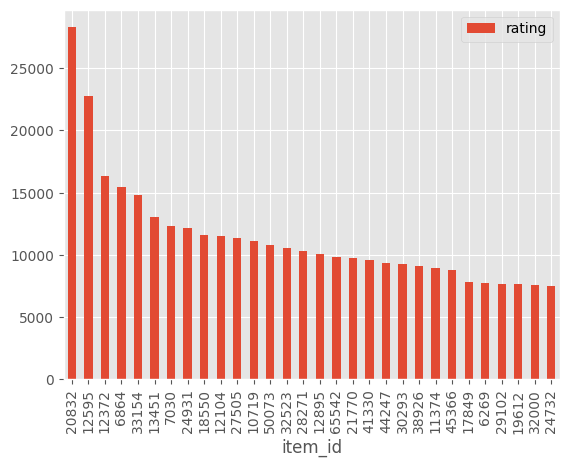

In [7]:
most_popular.head(30).plot(kind = "bar")

# Part 2

In [23]:
# Part 3: User-Based Recommendation Function
# This function combines Part 1 (popularity-based) and Part 2 (collaborative filtering)
# to provide personalized recommendations for a given user ID

def get_user_recommendations(user_id, num_recommendations=10):
    """
    Recommend top products for a given user ID based on their purchase history
    and collaborative filtering techniques.
    
    Parameters:
    user_id (str): The user ID for whom to generate recommendations
    num_recommendations (int): Number of recommendations to return (default: 10)
    
    Returns:
    list: Top recommended product IDs
    """
    
    # Check if user exists in the dataset
    if user_id not in ratings_utility_matrix.index:
        # print(f"User {user_id} not found. Returning popular products for new users...")
        # Fall back to popularity-based recommendations (Part 1)
        return most_popular.head(num_recommendations).index.tolist()
    
    # Get user's purchase history
    user_ratings = ratings_utility_matrix.loc[user_id]
    purchased_products = user_ratings[user_ratings > 0].index.tolist()
    
    if len(purchased_products) == 0:
        # print(f"User {user_id} has no purchase history. Returning popular products...")
        return most_popular.head(num_recommendations).index.tolist()
    
    # print(f"User {user_id} has purchased {len(purchased_products)} products.")
    # print(f"Sample purchased products: {purchased_products[:3]}")
    
    # Get recommendations based on collaborative filtering (Part 2)
    recommendation_scores = {}
    
    for product in purchased_products:
        if product in X.index:
            # Find the index of the product in correlation matrix
            product_idx = list(X.index).index(product)
            
            # Get correlations for this product
            product_correlations = correlation_matrix[product_idx]
            
            # Add scores for correlated products
            for i, correlation in enumerate(product_correlations):
                recommended_product = X.index[i]
                
                # Skip products already purchased
                if recommended_product not in purchased_products:
                    if recommended_product not in recommendation_scores:
                        recommendation_scores[recommended_product] = 0
                    recommendation_scores[recommended_product] += correlation
    
    # Sort recommendations by score
    sorted_recommendations = sorted(recommendation_scores.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True)
    
    # Extract top recommendations
    top_recommendations = [product for product, score in sorted_recommendations[:num_recommendations]]
    
    # If we don't have enough recommendations, fill with popular products
    if len(top_recommendations) < num_recommendations:
        popular_products_list = most_popular.index.tolist()
        for product in popular_products_list:
            if product not in top_recommendations and product not in purchased_products:
                top_recommendations.append(product)
                if len(top_recommendations) >= num_recommendations:
                    break
    
    return top_recommendations[:num_recommendations]

In [53]:
users_per_iteration = 15000
different_users = amazon_ratings['user_id'].unique()
different_users.shape[0]

# get the number of last index with user_id = 5000 from amazon_ratings
last_index = amazon_ratings[amazon_ratings['user_id'] == users_per_iteration].index.max()
iterations = int(different_users.shape[0]/users_per_iteration)
iterations

57

In [ ]:

# Get sorted unique user IDs for proper batching
unique_users = sorted(amazon_ratings['user_id'].unique())
total_users = len(unique_users)
iterations = (total_users + users_per_iteration - 1) // users_per_iteration  # Ceiling division

for i in range(iterations):
    start_idx = i * users_per_iteration
    end_idx = min((i + 1) * users_per_iteration, total_users)
    
    # Get actual user IDs for this batch
    batch_user_ids = unique_users[start_idx:end_idx]
    min_user_id = batch_user_ids[0]
    max_user_id = batch_user_ids[-1]
    
    # Filter ratings for users in this batch
    amazon_ratings1 = amazon_ratings[amazon_ratings['user_id'].isin(batch_user_ids)]
    
    # Create utility matrix for this batch
    ratings_utility_matrix = amazon_ratings1.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
    X = ratings_utility_matrix.T
    X1 = X
    SVD = TruncatedSVD(n_components=10)
    decomposed_matrix = SVD.fit_transform(X)
    correlation_matrix = np.corrcoef(decomposed_matrix)
    product_names = list(X.index)
    
    # Get test users for this batch
    test_users = pd.read_csv('../data/test.csv').iloc[start_idx:end_idx]

    def get_user_recommendations(user_id, num_recommendations=10):

        # Check if user exists in the dataset
        if user_id not in ratings_utility_matrix.index:
            # print(f"User {user_id} not found. Returning popular products for new users...")
            # Fall back to popularity-based recommendations (Part 1)
            return most_popular.head(num_recommendations).index.tolist()
        
        # Get user's purchase history
        user_ratings = ratings_utility_matrix.loc[user_id]
        purchased_products = user_ratings[user_ratings > 0].index.tolist()
        
        if len(purchased_products) == 0:
            # print(f"User {user_id} has no purchase history. Returning popular products...")
            return most_popular.head(num_recommendations).index.tolist()
        
        # print(f"User {user_id} has purchased {len(purchased_products)} products.")
        # print(f"Sample purchased products: {purchased_products[:3]}")
        
        # Get recommendations based on collaborative filtering (Part 2)
        recommendation_scores = {}
        
        for product in purchased_products:
            if product in X.index:
                # Find the index of the product in correlation matrix
                product_idx = list(X.index).index(product)
                
                # Get correlations for this product
                product_correlations = correlation_matrix[product_idx]
                
                # Add scores for correlated products
                for i, correlation in enumerate(product_correlations):
                    recommended_product = X.index[i]
                    
                    # Skip products already purchased
                    if recommended_product not in purchased_products:
                        if recommended_product not in recommendation_scores:
                            recommendation_scores[recommended_product] = 0
                        recommendation_scores[recommended_product] += correlation
        
        # Sort recommendations by score
        sorted_recommendations = sorted(recommendation_scores.items(), 
                                    key=lambda x: x[1], 
                                    reverse=True)
        
        # Extract top recommendations
        top_recommendations = [product for product, score in sorted_recommendations[:num_recommendations]]
        
        # If we don't have enough recommendations, fill with popular products
        if len(top_recommendations) < num_recommendations:
            popular_products_list = most_popular.index.tolist()
            for product in popular_products_list:
                if product not in top_recommendations and product not in purchased_products:
                    top_recommendations.append(product)
                    if len(top_recommendations) >= num_recommendations:
                        break
        
        return top_recommendations[:num_recommendations]
    
    # fill predictions with results of get_user_recommendations(3)

    predictions = []

    for user_id in test_users['user_id'].tolist():
        prediction = get_user_recommendations(user_id)
        final_prediction = []
        for item_id in prediction:
            final_prediction.append(int(item_id))
        predictions.append(final_prediction)

    submission = pd.DataFrame({
        'user_id': test_users['user_id'].tolist(), 
        'predictions': [' '.join(map(str, pred)) for pred in predictions]
    })
    print(f"Batch {i+1}/{iterations}: Processing users {min_user_id} to {max_user_id}")
    submission.to_csv(f"submission.csv", index=False, mode='a', header=(i==0))
    print(f"Submission saved: {submission.shape[0]:,} predictions")


# amazon_ratings1 = amazon_ratings.head(20000)
# ratings_utility_matrix = amazon_ratings1.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
# X = ratings_utility_matrix.T
# X1 = X
# SVD = TruncatedSVD(n_components=10)
# decomposed_matrix = SVD.fit_transform(X)
# correlation_matrix = np.corrcoef(decomposed_matrix)

# top_ids



In [8]:
amazon_ratings1 = amazon_ratings.head(20000)

In [9]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
ratings_utility_matrix.head()

item_id,39,58,64,65,67,90,91,104,149,160,...,77730,77761,77767,77775,77786,77789,77793,77801,77821,77825
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
ratings_utility_matrix.shape

(6725, 6531)

In [11]:
X = ratings_utility_matrix.T
X.head()

user_id,0,1,2,3,4,5,6,7,8,9,...,6715,6716,6717,6718,6719,6720,6721,6722,6723,6724
item_id,,,,,,,,,,,,,,,,,,,,,
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X.shape

(6531, 6725)

In [13]:
X1 = X

In [14]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(6531, 10)

In [15]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(6531, 6531)

In [16]:
X.index[99]

np.int64(2462)

In [17]:
i=3703

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

186

In [18]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(6531,)

In [19]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

[11538, 18830, 19514, 22180, 24080, 31763, 38234, 40174, 43945]

In [76]:
# Part 3: User-Based Recommendation Function
# This function combines Part 1 (popularity-based) and Part 2 (collaborative filtering)
# to provide personalized recommendations for a given user ID

def get_user_recommendations(user_id, num_recommendations=10):
    """
    Recommend top products for a given user ID based on their purchase history
    and collaborative filtering techniques.
    
    Parameters:
    user_id (str): The user ID for whom to generate recommendations
    num_recommendations (int): Number of recommendations to return (default: 10)
    
    Returns:
    list: Top recommended product IDs
    """
    
    # Check if user exists in the dataset
    if user_id not in ratings_utility_matrix.index:
        print(f"User {user_id} not found. Returning popular products for new users...")
        # Fall back to popularity-based recommendations (Part 1)
        return most_popular.head(num_recommendations).index.tolist()
    
    # Get user's purchase history
    user_ratings = ratings_utility_matrix.loc[user_id]
    purchased_products = user_ratings[user_ratings > 0].index.tolist()
    
    if len(purchased_products) == 0:
        print(f"User {user_id} has no purchase history. Returning popular products...")
        return most_popular.head(num_recommendations).index.tolist()
    
    print(f"User {user_id} has purchased {len(purchased_products)} products.")
    print(f"Sample purchased products: {purchased_products[:3]}")
    
    # Get recommendations based on collaborative filtering (Part 2)
    recommendation_scores = {}
    
    for product in purchased_products:
        if product in X.index:
            # Find the index of the product in correlation matrix
            product_idx = list(X.index).index(product)
            
            # Get correlations for this product
            product_correlations = correlation_matrix[product_idx]
            
            # Add scores for correlated products
            for i, correlation in enumerate(product_correlations):
                recommended_product = X.index[i]
                
                # Skip products already purchased
                if recommended_product not in purchased_products:
                    if recommended_product not in recommendation_scores:
                        recommendation_scores[recommended_product] = 0
                    recommendation_scores[recommended_product] += correlation
    
    # Sort recommendations by score
    sorted_recommendations = sorted(recommendation_scores.items(), 
                                  key=lambda x: x[1], 
                                  reverse=True)
    
    # Extract top recommendations
    top_recommendations = [product for product, score in sorted_recommendations[:num_recommendations]]
    
    # If we don't have enough recommendations, fill with popular products
    if len(top_recommendations) < num_recommendations:
        popular_products_list = most_popular.index.tolist()
        for product in popular_products_list:
            if product not in top_recommendations and product not in purchased_products:
                top_recommendations.append(product)
                if len(top_recommendations) >= num_recommendations:
                    break
    
    return top_recommendations[:num_recommendations]


In [77]:
get_user_recommendations(3)

User 3 has purchased 8 products.
Sample purchased products: [19746, 27832, 28206]


[np.int64(50260),
 np.int64(43787),
 np.int64(45382),
 np.int64(48214),
 np.int64(50625),
 np.int64(56147),
 np.int64(50938),
 np.int64(44009),
 np.int64(24931),
 np.int64(48316)]

In [78]:
test_users = pd.read_csv('../data/test.csv')
# fill predictions with results of get_user_recommendations(3)

predictions = []

for user_id in test_users['user_id'].tolist():
    prediction = get_user_recommendations(user_id)
    final_prediction = []
    for item_id in prediction:
        final_prediction.append(int(item_id))
    predictions.append(final_prediction)

submission = pd.DataFrame({
    'user_id': test_users['user_id'].tolist(), 
    'predictions': [' '.join(map(str, pred)) for pred in predictions]
})
submission.to_csv("submission.csv", index=False)
print(f"Submission saved: {submission.shape[0]:,} predictions")


User 0 has purchased 7 products.
Sample purchased products: [7314, 15265, 15493]
User 1 has purchased 2 products.
Sample purchased products: [23511, 32725]
User 3 has purchased 8 products.
Sample purchased products: [19746, 27832, 28206]
User 5 has purchased 5 products.
Sample purchased products: [7030, 21542, 39808]
User 6 has purchased 3 products.
Sample purchased products: [41792, 68944, 72796]
User 7 has purchased 2 products.
Sample purchased products: [12595, 15662]
User 8 has purchased 3 products.
Sample purchased products: [6269, 12298, 25392]
User 9 has purchased 2 products.
Sample purchased products: [18550, 27271]
User 10 has purchased 2 products.
Sample purchased products: [9833, 10799]
User 11 has purchased 2 products.
Sample purchased products: [28271, 30207]
User 14 has purchased 3 products.
Sample purchased products: [25183, 28159, 35041]
User 15 has purchased 6 products.
Sample purchased products: [3782, 12996, 13500]
User 21 has purchased 2 products.
Sample purchased p

KeyboardInterrupt: 

# Part 3

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [80]:
product_descriptions = pd.read_csv('../data/item_metadata_filtered.csv')
product_descriptions.shape

(77833, 15)

In [81]:
product_descriptions = product_descriptions.dropna()
product_descriptions.shape

(48333, 15)

In [82]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]
product_descriptions1["description"].head(10)


6                                                    []
12    ['Your feet go through so much every day and h...
16    ["Clear Essence Specialist Skincare Body Oil i...
17    ['African Pride Black Castor Miracle Hold & Co...
30                                                   []
31                                                   []
33    ["Body Fantasies Signature Vanilla by Parfums ...
35    ['MoYo Natural Labs SPRAY BOTTLE 8 OZ HDPE pla...
37                                                   []
39                                                   []
Name: description, dtype: object

In [83]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["description"])
X1

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8473 stored elements and shape (500, 3717)>

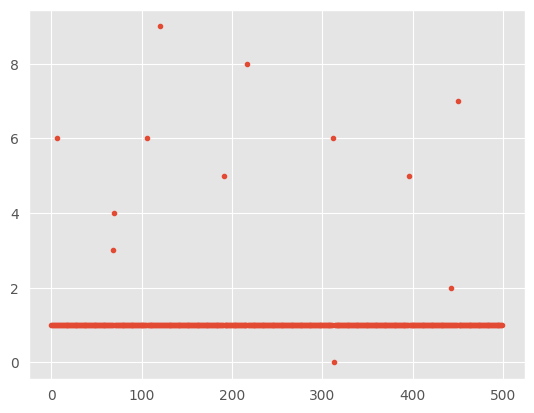

In [84]:
X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++', max_iter=1000000, n_init=100)
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

best k = 13  (silhouette = 0.421)


/home/xowski22/PycharmProjects/Team_4_DSC/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/xowski22/PycharmProjects/Team_4_DSC/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


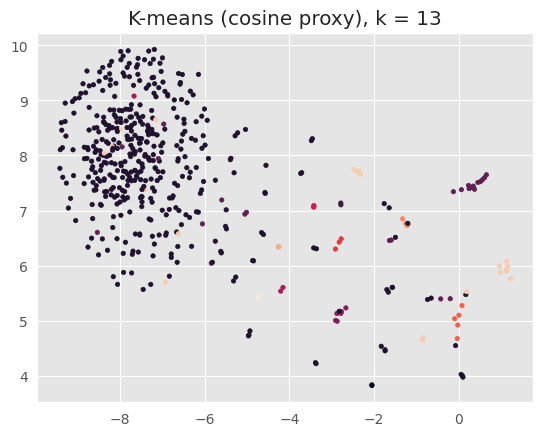

In [106]:
# -----------------------------------------------------------
# 1.  Vectorise and put every document on the unit sphere
# -----------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
import pandas as pd      # only for convenience; can omit

# ── load / prepare your text column ─────────────────────────
texts = product_descriptions1["description"].fillna("").tolist()

vec = TfidfVectorizer(stop_words="english", min_df=3)
X   = vec.fit_transform(texts)          # sparse (n_samples × n_terms)

# L2-normalise so that ||row||₂ = 1  →  cosine ∝ Euclidean
X_unit = normalize(X, norm="l2", copy=False)

# -----------------------------------------------------------
# 2.  Reduce dimensionality with truncated SVD (LSA)
# -----------------------------------------------------------
svd = TruncatedSVD(n_components=100, random_state=0)
X_red = svd.fit_transform(X_unit)       # dense (n_samples × 100)

# -----------------------------------------------------------
# 3.  Pick the optimal k by silhouette on the reduced space
# -----------------------------------------------------------
k_range = range(2, 15)
sil_scores = []

for k in k_range:
    km = KMeans(n_clusters=k, init="k-means++", n_init=20, random_state=0)
    labels = km.fit_predict(X_red)
    sil_scores.append(silhouette_score(X_red, labels))

best_k = k_range[int(np.argmax(sil_scores))]
print(f"best k = {best_k}  (silhouette = {max(sil_scores):.3f})")

# -----------------------------------------------------------
# 4.  Final K-means with the chosen k
# -----------------------------------------------------------
kmeans  = KMeans(n_clusters=best_k, init="k-means++", n_init=50, random_state=0)
labels  = kmeans.fit_predict(X_red)

# optional: renormalise centroids (keeps them on the unit sphere)
kmeans.cluster_centers_ = normalize(kmeans.cluster_centers_, norm="l2")

# -----------------------------------------------------------
# 5.  2-D visualisation with UMAP
# -----------------------------------------------------------
embedding = umap.UMAP(random_state=0).fit_transform(X_red)
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=10)
plt.title(f"K-means (cosine proxy), k = {best_k}")
plt.show()

In [107]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [108]:
# # Optimal clusters is 

true_k = 10

# model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
# model.fit(X1)

print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names_out()
for i in range(true_k):
    print_cluster(i)

Top terms per cluster:
Cluster 0:
 150
 18
 50
 15
 blended
 added
 african
 base
 assorted
 aloe
Cluster 1:
 10
 20
 35
 acid
 alloy
 60
 bar
 blades
 18
 alcohol
Cluster 2:
 18
 12
 40
 97
 alcohol
 150
 acids
 28
 35
 10
Cluster 3:
 10
 100
 100ml
 14
 28
 24
 150
 allow
 applying
 97
Cluster 4:
 14
 15
 10
 40
 allow
 50
 adhesive
 applying
 avoid
 25
Cluster 5:
 adults
 amber
 75
 accessory
 25
 applicator
 adhesive
 absorbed
 10
 28
Cluster 6:
 24
 16
 28
 15
 60
 acid
 achieve
 accessory
 action
 40
Cluster 7:
 50
 18
 achieve
 ages
 28
 aging
 10
 60
 30
 adult
Cluster 8:
 10
 100ml
 accessory
 30
 15
 100
 60
 25
 action
 accessories
Cluster 9:
 12
 10
 14
 50
 16
 achieve
 adhesive
 add
 avoid
 beautiful


In [117]:
def show_recommendations(product):
    #print("Cluster ID:")
    Y = vec.transform([product])
    Y_unit = normalize(Y, norm="l2", copy=False)
    Y_red = svd.transform(Y_unit)

    prediction = kmeans.predict(Y_red)
    #print(prediction)
    print_cluster(prediction[0])

In [113]:
def print_cluster(i):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [123]:
show_recommendations("cutting tool")

Cluster 1:
 10
 20
 35
 acid
 alloy
 60
 bar
 blades
 18
 alcohol
